In [1]:
# 定义标签映射
label_map = {
    0: 'disgust',
    1: 'happiness',
    2: 'others',
    3: 'repression',
    4: 'surprise'
}

In [2]:
import os
import random
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# 假设的数据根目录
root_dir = '/gemini/data-1'

# 假设所有图片的目标尺寸
target_size = (128, 128)

def load_data(root_dir, target_size, sequence_length=32):
    labels = ['disgust', 'happiness', 'others', 'repression', 'surprise']
    label_indices = {label: idx for idx, label in enumerate(labels)}

    # 为每种表情定义不同的循环次数
    repeats_per_label = {
        'disgust': 8,
        'happiness': 16,
        'others': 5,
        'repression': 19,
        'surprise': 20
    }
    
    sequences = []
    sequence_labels = []

    for label in labels:
        label_dir = os.path.join(root_dir, label)
        repeat_times = repeats_per_label[label]  # 获取当前标签的循环次数
        
        for sequence_dir in os.listdir(label_dir):
            sequence_path = os.path.join(label_dir, sequence_dir)
            if os.path.isdir(sequence_path):
                frames = sorted(os.listdir(sequence_path))
                num_frames = len(frames)

                if num_frames >= sequence_length:
                    for _ in range(repeat_times):
                        start_frame = random.randint(0, num_frames - sequence_length)
                        selected_frames = frames[start_frame:start_frame + sequence_length]
                        
                        sequence = []
                        for frame in selected_frames:
                            frame_path = os.path.join(sequence_path, frame)
                            img = load_img(frame_path, target_size=target_size, color_mode='grayscale')  # 加载为灰度图
                            img_array = img_to_array(img)
                            img_array = img_array / 255.0  # 归一化
                            sequence.append(img_array)

                        sequences.append(np.array(sequence))
                        sequence_labels.append(label_indices[label])

    return sequences, sequence_labels

2024-05-11 03:23:54.373962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 03:23:54.550657: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-11 03:23:57.848425: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-11 03:23:59.899202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## 导入图像数据

In [3]:
sequences, sequence_labels = load_data(root_dir, target_size)
print(len(sequences), len(sequence_labels))

2461 2461


In [4]:
# 计算每个标签的序列数量
label_counts = {label: 0 for label in ['disgust', 'happiness', 'others', 'repression', 'surprise']}

for label_index, _ in enumerate(sequence_labels):
    label = ['disgust', 'happiness', 'others', 'repression', 'surprise'][sequence_labels[label_index]]
    label_counts[label] += 1

# 打印每个标签的时序数量
for label, count in label_counts.items():
    print(f"Label '{label}' has {count} sequences.")


Label 'disgust' has 496 sequences.
Label 'happiness' has 496 sequences.
Label 'others' has 475 sequences.
Label 'repression' has 494 sequences.
Label 'surprise' has 500 sequences.


In [5]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# 将标签转换为one-hot编码
sequence_labels = to_categorical(sequence_labels)



In [6]:
# # 找出最长的序列长度
# # max_seq_length = max(len(seq) for seq in sequences)
# max_seq_length=60
# # 将所有序列填充（或截断）到这个长度
# padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
#     sequences, maxlen=max_seq_length, dtype='float32', padding='post', truncating='post', value=0.0)

sequences[1].shape

(32, 128, 128, 1)

## 划分训练集和测试集

In [7]:
from sklearn.model_selection import train_test_split

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(np.array(sequences), sequence_labels, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1968, 32, 128, 128, 1) (493, 32, 128, 128, 1) (1968, 5) (493, 5)


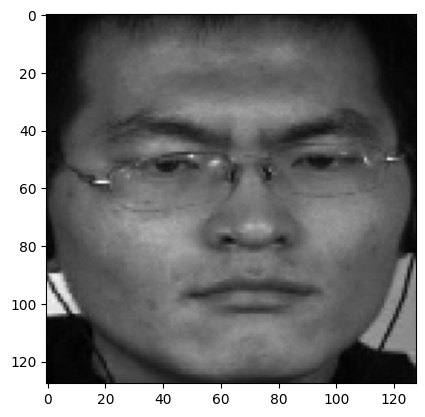

In [8]:
import matplotlib.pyplot as plt
plt.imshow(X_train[1][0].reshape(128, 128), cmap='gray')

## 图像增强

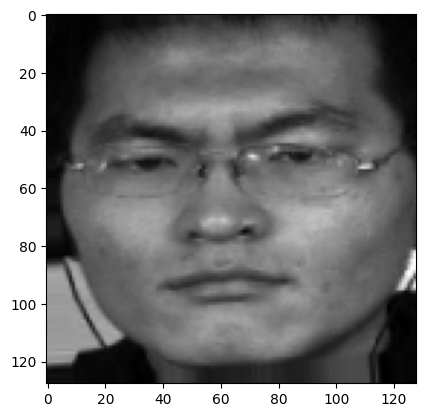

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 初始化ImageDataGenerator
data_gen = ImageDataGenerator(
    rotation_range=5,  # 随机旋转的度数范围
    width_shift_range=0.05,  # 水平移动的范围（相对总宽度的比例）
    height_shift_range=0.05,  # 垂直移动的范围（相对总高度的比例）
    zoom_range=0.05,  # 随机缩放的范围
    horizontal_flip=True,  # 是否进行随机水平翻转
    fill_mode='nearest'  # 用于填充新创建像素的策略
)

def augment_sequence(sequence, data_gen):
    # 获取增强参数
    params = data_gen.get_random_transform(sequence[0].shape)
    
    # 应用增强到序列的每一帧
    augmented_sequence = []
    for frame in sequence:
        augmented_frame = data_gen.apply_transform(frame, params)
        augmented_sequence.append(augmented_frame)

    return np.array(augmented_sequence)

# 然后只对训练数据进行增强
X_train_augmented = []
for sequence in X_train:
    # 增强整个序列，这个函数需要您根据之前的讨论自行实现
    augmented_sequence = augment_sequence(sequence, data_gen)
    X_train_augmented.append(augmented_sequence)
plt.imshow(X_train_augmented[1][0].reshape(128, 128), cmap='gray')

# 将增强后的训练数据用于模型训练
X_train = np.array(X_train_augmented)

In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1968, 32, 128, 128, 1) (493, 32, 128, 128, 1) (1968, 5) (493, 5)


## 显示数据集的序列数量标签

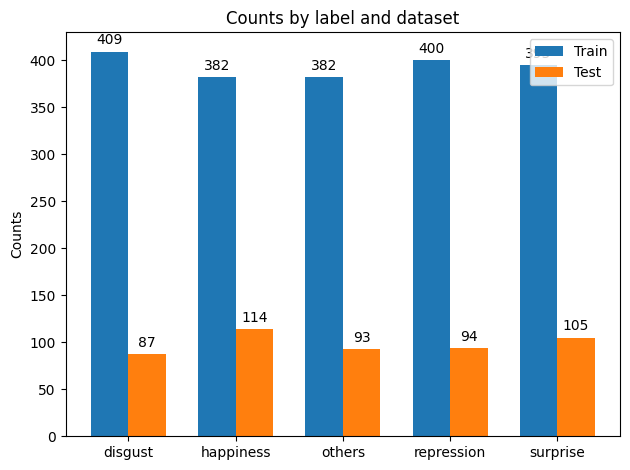

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 假设y_train和y_test是已经转换成独热编码的标签数组
# y_train的形状为(612, 7)，y_test的形状为(153, 7)

# 由于标签已经转换成独热编码，我们可以通过求和来统计每个标签的数量
train_counts = np.sum(y_train, axis=0)
test_counts = np.sum(y_test, axis=0)

# 创建标签
labels = ['disgust', 'happiness', 'others', 'repression', 'surprise']

# 创建柱状图
x = np.arange(len(labels))  # 标签位置
width = 0.35  # 柱状图的宽度

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
rects2 = ax.bar(x + width/2, test_counts, width, label='Test')

# 添加文本标签、标题和自定义x轴标签位置
ax.set_ylabel('Counts')
ax.set_title('Counts by label and dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 添加数据标签
def autolabel(rects):
    """附加一个文本标签在每个柱形图上方显示高度。"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3点垂直偏移
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


## 模型训练

In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from keras.layers import Multiply, Permute, Reshape, Lambda
import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from keras.models import load_model
from keras.models import Model
from keras.regularizers import l1, l2

def attention_block(inputs, time_steps):
    # 输入形状为 (batch_size, time_steps, features)
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    a_probs = Permute((2, 1))(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def create_lstm_model(cnn_model, sequence_length, num_classes):
    input_layer = Input(shape=(sequence_length, 128, 128, 1))
    cnn_out = TimeDistributed(cnn_model)(input_layer)
    
    lstm_out = LSTM(128, return_sequences=True)(cnn_out)
    # 应用注意力机制
    attention_mul = attention_block(lstm_out, sequence_length)
        
    lstm_out = LSTM(64, return_sequences=False)(lstm_out)
    lstm_out = Dropout(0.3)(lstm_out)  # 应用Dropout
    
    lstm_out = Dense(32, activation='relu')(lstm_out)
    lstm_out = Dropout(0.5)(lstm_out)  # 应用Dropout
    
    output_layer = Dense(num_classes, activation='softmax')(lstm_out)
    return Model(input_layer, output_layer)


class GradientClippingCallback(Callback):
    def __init__(self, model, clip_norm=1.0):
        super(GradientClippingCallback, self).__init__()
        self.model = model
        self.clip_norm = clip_norm

    def on_batch_begin(self, batch, logs=None):
        self.loss = []
        self.gradients = []

    def on_batch_end(self, batch, logs=None):
        # Get loss
        loss = logs['loss']
        self.loss.append(loss)

        # Get gradients
        with tf.GradientTape() as tape:
            tape.watch(self.model.trainable_weights)
            loss_value = tf.convert_to_tensor(loss, dtype=tf.float32)
            gradients = tape.gradient(loss_value, self.model.trainable_weights)

        # gradients = tape.gradient(loss_value, self.model.trainable_weights)
        # self.gradients.extend([grad for grad in gradients if grad is not None])
        # Normalize gradients
        non_none_gradients = [g for g in gradients if g is not None]
        gradient_norm = tf.sqrt(tf.math.reduce_sum([tf.reduce_sum(tf.square(g)) for g in non_none_gradients]))
        normalized_gradients = [g / gradient_norm if g is not None else g for g in gradients]

        # Clip gradients
        clipped_gradients = [K.clip(grad, -self.clip_norm, self.clip_norm) for grad in self.gradients]

        # Update gradients
        self.model.optimizer.apply_gradients(zip([grad for grad in clipped_gradients if grad is not None], self.model.trainable_weights))

        self.gradients = []

# 创建CNN模型
cnn_model = load_model('models/cnn_casme2_0330_1945ACC93.h5')
# new_cnn = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)
new_cnn = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)
for layer in new_cnn.layers:
    layer.trainable = False

max_seq_length=32
# 创建LSTM模型
lstm_model = create_lstm_model(new_cnn, sequence_length=max_seq_length, num_classes=5)

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=2.5e-5)
# 设置 EarlyStopping 回调函数
early_stopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
# 编译模型
optimizer = SGD(learning_rate=0.0001, momentum=0.9)
# optimizer = Adam(learning_rate=0.001)  # 使用Adam优化器
lstm_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

grad_clipper = GradientClippingCallback(lstm_model,clip_norm=0.1)
history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=24, epochs=100, callbacks=[lr_reducer, early_stopper, grad_clipper])

Epoch 1/100


2024-05-11 03:35:06.921570: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-05-11 03:35:31.561663: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


82/82 [==============================] - 60s 217ms/step - loss: 1.6087 - accuracy: 0.2525 - val_loss: 1.4941 - val_accuracy: 0.3976 - lr: 1.0000e-04
Epoch 2/100
82/82 [==============================] - 15s 181ms/step - loss: 1.4729 - accuracy: 0.3786 - val_loss: 1.4057 - val_accuracy: 0.5233 - lr: 1.0000e-04
Epoch 3/100
82/82 [==============================] - 13s 164ms/step - loss: 1.4091 - accuracy: 0.4172 - val_loss: 1.3255 - val_accuracy: 0.5314 - lr: 1.0000e-04
Epoch 4/100
82/82 [==============================] - 14s 166ms/step - loss: 1.3481 - accuracy: 0.4441 - val_loss: 1.2594 - val_accuracy: 0.5740 - lr: 1.0000e-04
Epoch 5/100
82/82 [==============================] - 13s 159ms/step - loss: 1.2829 - accuracy: 0.5020 - val_loss: 1.1739 - val_accuracy: 0.6065 - lr: 1.0000e-04
Epoch 6/100
82/82 [==============================] - 13s 158ms/step - loss: 1.2281 - accuracy: 0.5229 - val_loss: 1.1223 - val_accuracy: 0.6308 - lr: 1.0000e-04
Epoch 7/100
82/82 [===========================

In [14]:
lstm_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 128, 128, 1)  0         
                             ]                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 32, 32768)        2074112   
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 32, 128)           16843264  
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080

## 训练结果查看：准确率与损失函数

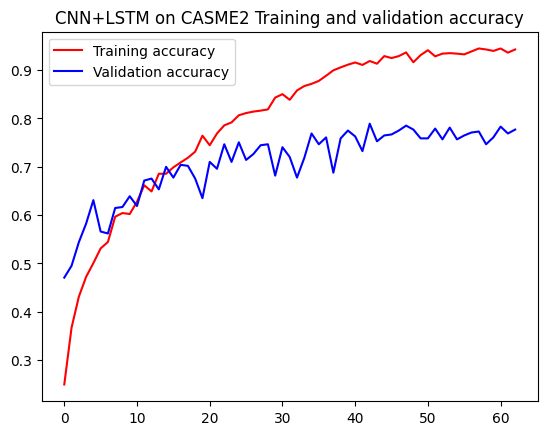

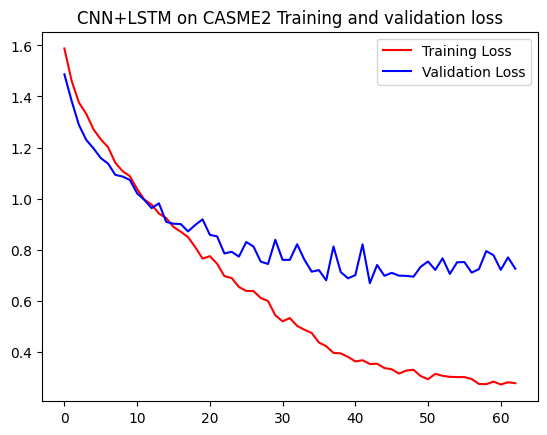

In [12]:
# 获取准确率与损失函数情况
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# matplotlib绘制训练过程中指标的变化状况
epochs = range(len(acc))

import matplotlib.pyplot as plt
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('CNN+LSTM on CASME2 Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('CNN+LSTM on CASME2 Training and validation loss')
plt.legend()

plt.show()

In [13]:
# 保存模型
lstm_model.save('models/lstm_casme2_0418_1652ACC7890.h5')

## 混淆矩阵

2024-04-19 09:28:56.774370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 09:29:02.164432: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-19 09:29:02.164489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22150 MB memory:  -> device: 0, name: S2.gpu.large, pci bus id: 0000:d1:00.0, compute capability: 8.6
2024-04-19 09:29:13.837646: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


 1/16 [>.............................] - ETA: 6:18

2024-04-19 09:29:30.845778: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


16/16 [==============================] - 29s 231ms/step


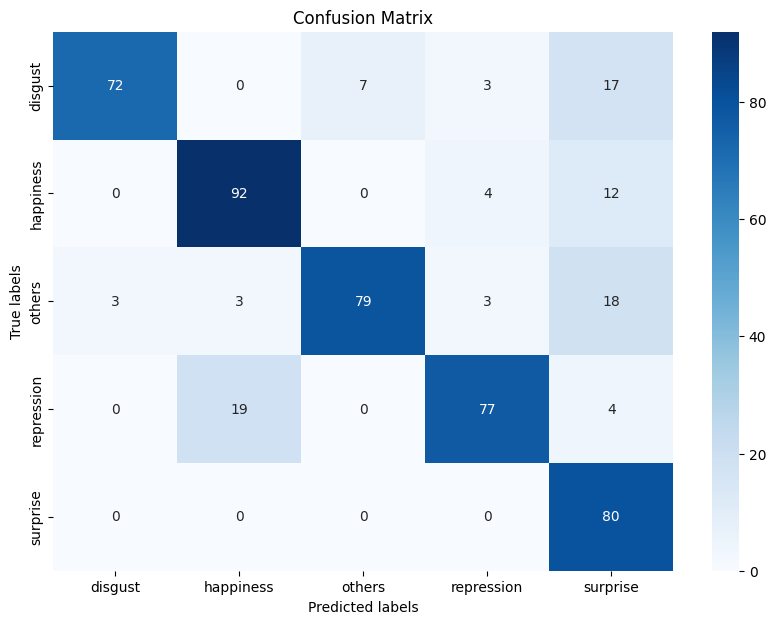

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # 用于更好的热图可视化
from keras.models import load_model
lstm_model = load_model('models/lstm_casme2_0418_1652ACC7890.h5')
# 假设 model 是你的模型, X_test 是测试数据
predictions = lstm_model.predict(X_test)

# 将独热编码的预测结果和真实标签转换回类别索引
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# 生成混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


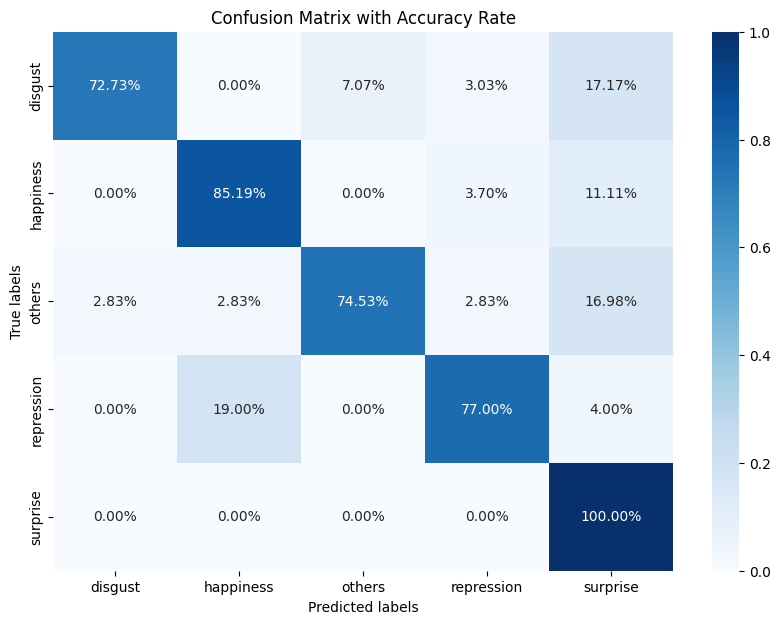

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 假设 y_pred 是你的预测类别索引，y_true 是真实类别索引
# cm = confusion_matrix(y_true, y_pred)  # 已经生成了混淆矩阵

# 归一化混淆矩阵
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 绘制归一化后的混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Accuracy Rate')
plt.show()


In [24]:
import numpy as np

def preprocess_single_image(image_path, target_size, sequence_length=32):
    img = load_img(image_path, target_size=target_size, color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # 归一化
    img_array = np.expand_dims(img_array, axis=0)  # 增加批处理维度

    # 正确地沿着序列长度的维度重复图片
    img_array = np.repeat(img_array, 32, axis=0)
    img_array = np.expand_dims(img_array, axis=0)  # 再次增加一个维度以匹配模型输入的期望形状
    print(img_array.shape)
    return img_array

# 假设'image_path'是你要预测的图像的路径
image_path = '../data-1/happiness/EP01_01/img114.jpg'
single_image = preprocess_single_image(image_path, target_size=(128, 128))

# 使用模型进行预测
predictions = lstm_model.predict(single_image)
pre = label_map[np.argmax(predictions)]
predictions,pre

(1, 32, 128, 128, 1)
1/1 [==============================] - 0s 46ms/step


(array([[0.13892546, 0.31332704, 0.1367826 , 0.02145439, 0.38951045]],
       dtype=float32),
 'surprise')